In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# Visualization
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
%pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
%pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
%pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Dataset

In [4]:
from torch_geometric.datasets import Planetoid
# https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/actor.html#Actor
dataset = Planetoid(root='.', name="Pubmed")
# dataset = Planetoid(root='.', name="Cora")

data = dataset[0] 

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}') 
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')


print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


# Mini-batching

Subgraph 0: Data(x=[406, 500], edge_index=[2, 460], y=[406], train_mask=[406], val_mask=[406], test_mask=[406], n_id=[406], e_id=[460], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[265, 500], edge_index=[2, 318], y=[265], train_mask=[265], val_mask=[265], test_mask=[265], n_id=[265], e_id=[318], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[270, 500], edge_index=[2, 312], y=[270], train_mask=[270], val_mask=[270], test_mask=[270], n_id=[270], e_id=[312], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[195, 500], edge_index=[2, 227], y=[195], train_mask=[195], val_mask=[195], test_mask=[195], n_id=[195], e_id=[227], input_id=[12], batch_size=12)


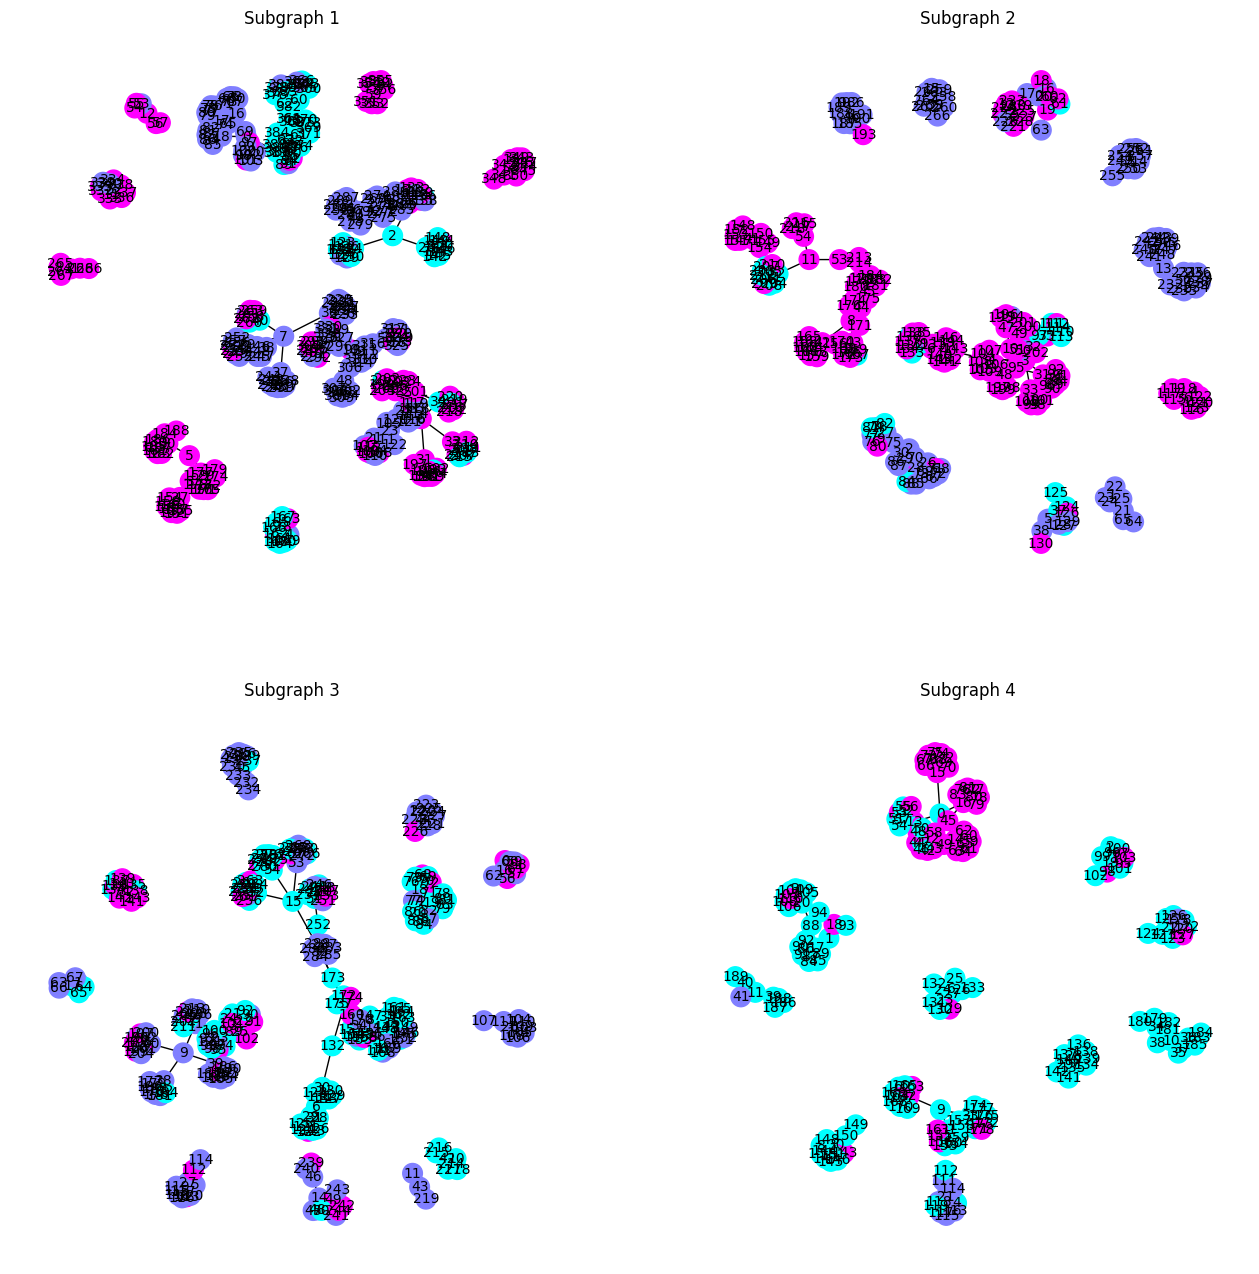

In [5]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(16,16))


for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx+1}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )



# Dataset Graph

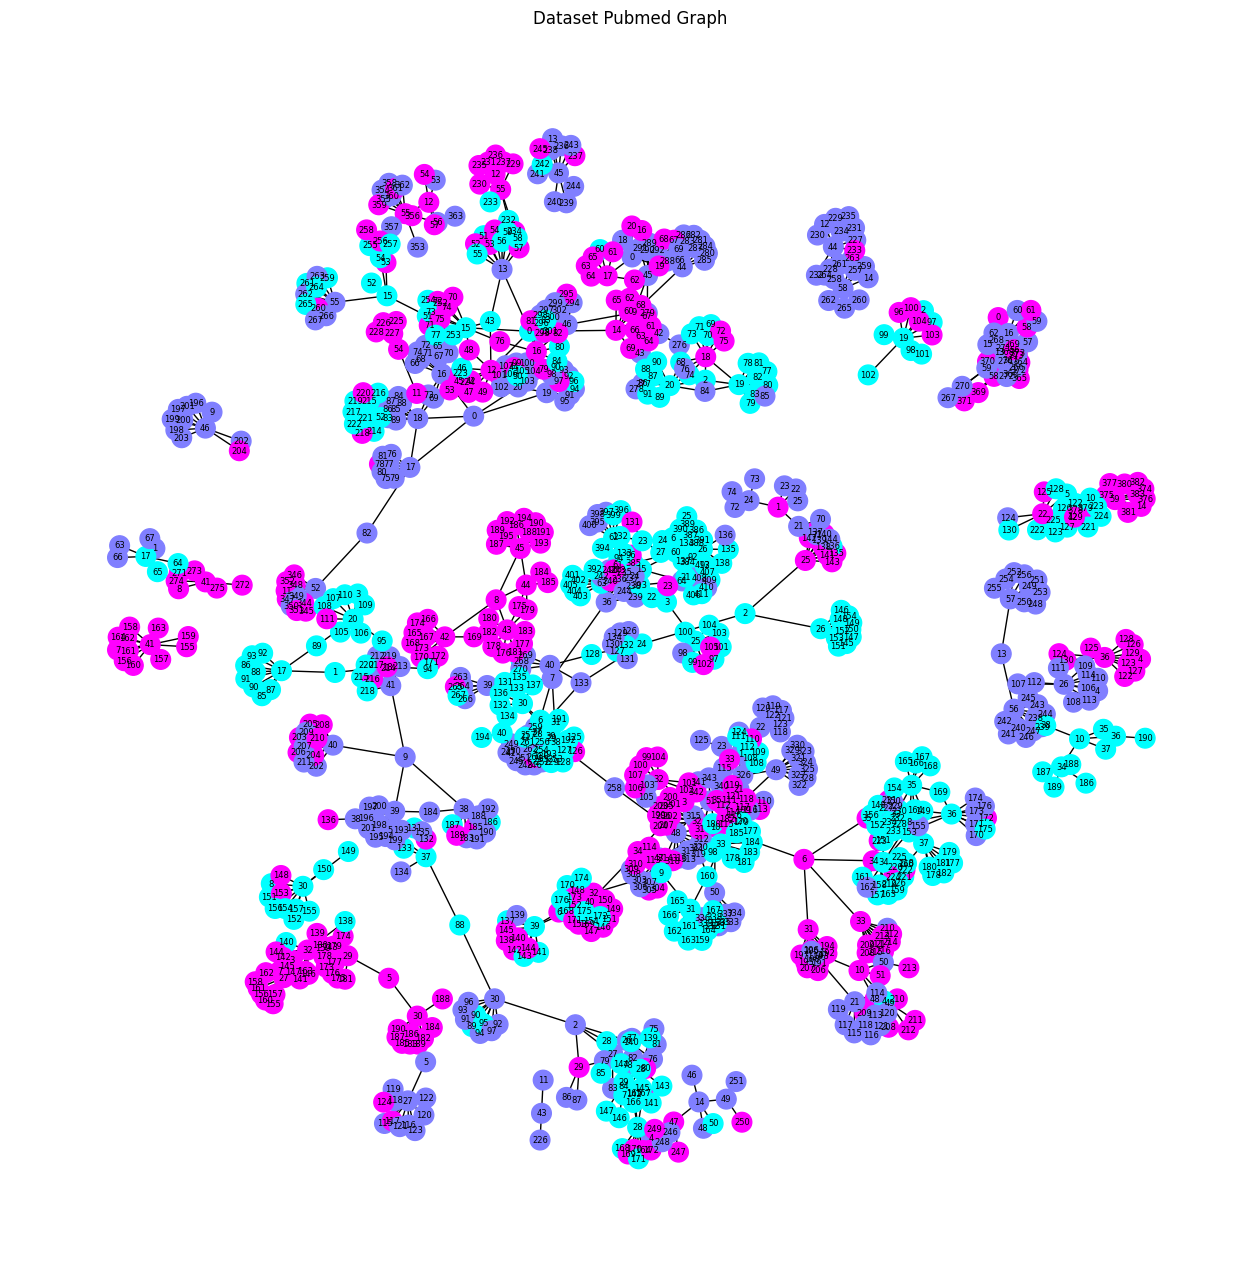

In [6]:
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

plt.figure(figsize=(16, 16))


for idx, subdata in enumerate(train_loader):
    G = to_networkx(subdata, to_undirected=True)  
    pos = nx.spring_layout(G, seed=0) 
    nx.draw_networkx(G,
                     pos=pos,
                     with_labels=True,
                     node_size=200,
                     node_color=subdata.y,
                     cmap='cool',
                     font_size=6,
                     label=f'Subgraph {idx}') 

plt.title(f'Dataset {dataset.name} Graph') 
plt.axis('off')  
plt.show()  


# Plot node degrees

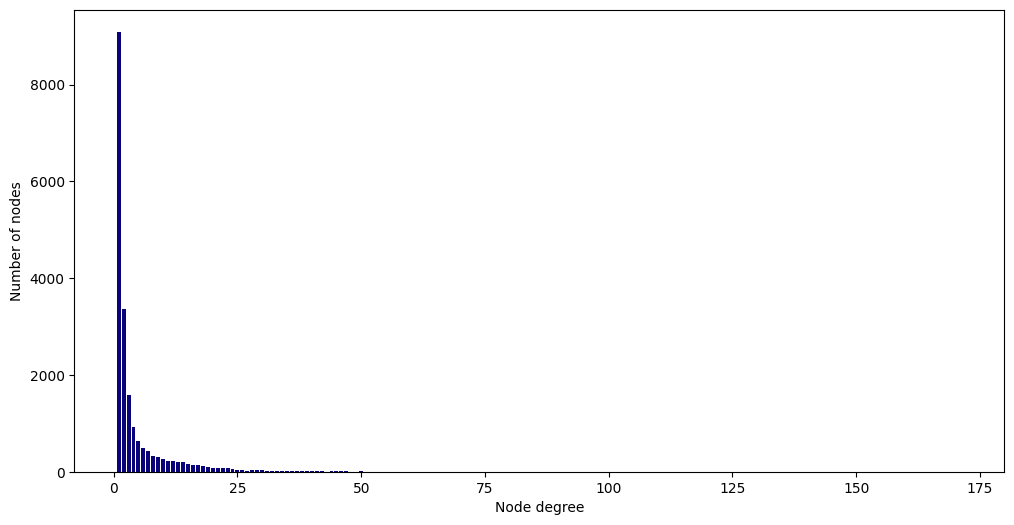

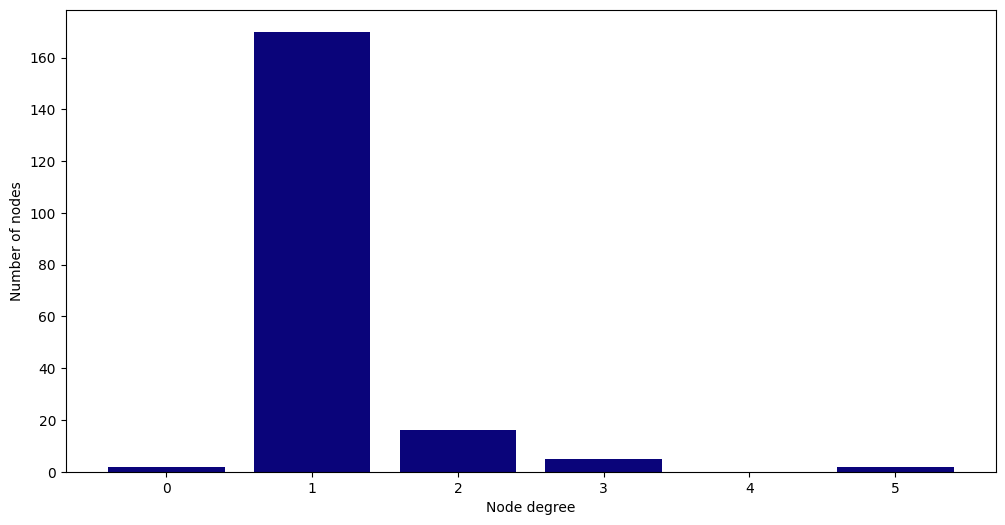

In [7]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

# Implement GraphSage

In [8]:
class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h

    def fit(self, data, train_loader, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = self.optimizer

        self.train()
        for epoch in range(epochs + 1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in train_loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

            # Print metrics every 10 epochs
            if epoch % 10 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {total_loss / len(train_loader):.3f} '
                      f'| Train Acc: {acc / len(train_loader) * 100:>6.2f}% | Val Loss: '
                      f'{val_loss / len(train_loader):.2f} | Val Acc: '
                      f'{val_acc / len(train_loader) * 100:.2f}%')


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()


def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GraphSAGE

In [11]:
# Create DataLoader for training
from torch_geometric.loader import DataLoader

train_loader = DataLoader([data], batch_size=1, shuffle=True)

# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes) # 64 hidden units, 7 classes, 1433 features
print(graphsage) 

# Train
graphsage.fit(data, train_loader, 200) 

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data) * 100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 1.100 | Train Acc:  33.33% | Val Loss: 1.09 | Val Acc: 41.60%
Epoch  10 | Train Loss: 0.415 | Train Acc:  95.00% | Val Loss: 0.76 | Val Acc: 74.40%
Epoch  20 | Train Loss: 0.054 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 75.60%
Epoch  30 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 0.66 | Val Acc: 76.40%
Epoch  40 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 77.20%
Epoch  50 | Train Loss: 0.029 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 75.80%
Epoch  60 | Train Loss: 0.019 | Train Acc: 100.00% | Val Loss: 0.65 | Val Acc: 76.80%
Epoch  70 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 78.80%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 77.20%
Epoch  90 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.65 | Val Acc: 78.00%
Epoch 100 | Train Loss: 0.017 | Train Acc: 100.00

# Vector

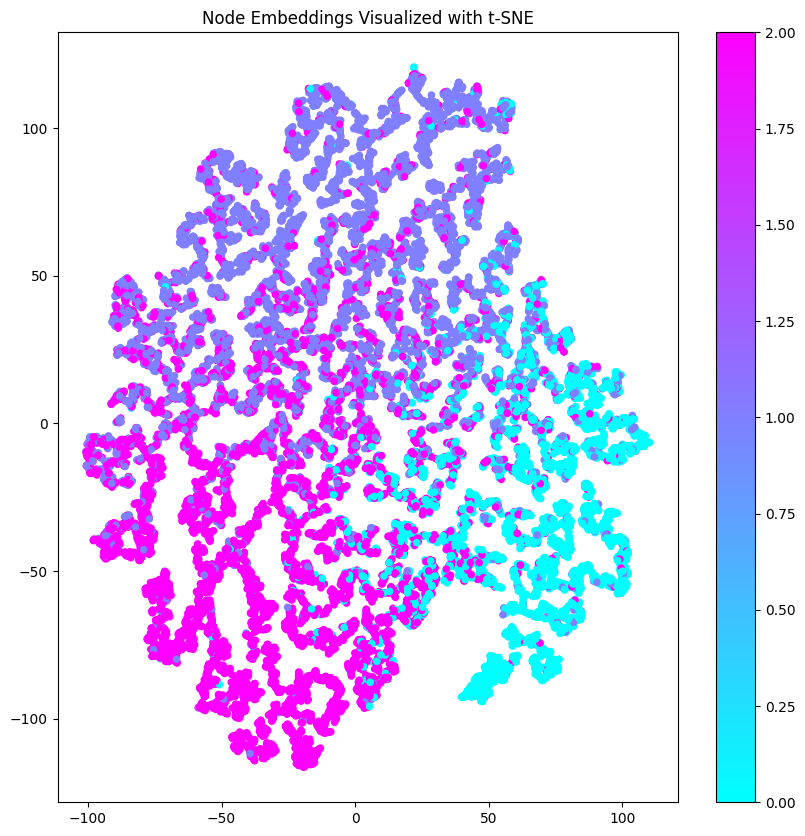

In [26]:
# Get the node embeddings
graphsage.eval() # Set model to evaluation mode
with torch.no_grad(): 
    embeddings = graphsage(data.x, data.edge_index)

# Visualize the node embeddings using t-SNE
embeddings_2d = TSNE(n_components=2).fit_transform(embeddings.numpy())

plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=data.y.numpy(), cmap='cool', s=20)
plt.colorbar()
plt.title('Node Embeddings Visualized with t-SNE')
plt.show()
